# 📈 Regression Models for HyperFaaS Resource Prediction


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import yaml
import sys
from pathlib import Path

sys.path.append('../../models/regression')
sys.path.append('../../src/models')

from linear_models import LinearRegressionModel, PolynomialRegressionModel, RidgeRegressionModel, LassoRegressionModel

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 📊 1. Load and Explore Data

In [18]:
df = pd.read_csv('../../data/processed/training.csv')

feature_columns = [
    'hyperfaas-thumbnailer-json:latest_active_calls',
    'hyperfaas-bfs-json:latest_active_calls', 
    'hyperfaas-echo:latest_active_calls'
]
target_columns = ['cpu_usage', 'memory_usage']

X = df[feature_columns].values
y = df[target_columns].values


X = np.nan_to_num(X, nan=0.0)
y = np.nan_to_num(y, nan=0.0)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 🤖 2. Train All Regression Models

In [20]:
model_configs = {
    'linear_regression': {
        'type': 'regression',
        'hyperparameters': {'fit_intercept': True}
    },
    'polynomial_regression': {
        'type': 'regression', 
        'hyperparameters': {'degree': 2, 'fit_intercept': True}
    },
    'ridge_regression': {
        'type': 'regression',
        'hyperparameters': {'alpha': 1.0, 'fit_intercept': True}
    },
    'lasso_regression': {
        'type': 'regression',
        'hyperparameters': {'alpha': 1.0, 'fit_intercept': True}
    }
}

model_classes = {
    'linear_regression': LinearRegressionModel,
    'polynomial_regression': PolynomialRegressionModel,
    'ridge_regression': RidgeRegressionModel,
    'lasso_regression': LassoRegressionModel
}

In [21]:
trained_models = {}
results = {}

for model_name, config in model_configs.items():
    print(f"\n🏋️ Training {model_name}...")
    
    model = model_classes[model_name](config)
    model.feature_names = feature_columns
    model.target_names = target_columns
    
    # Train
    history = model.train(X_train_scaled, y_train, X_val_scaled, y_val)
    
    # Evaluate
    test_metrics = model.evaluate(X_test_scaled, y_test)
    test_predictions = model.predict(X_test_scaled)
    
    trained_models[model_name] = model
    results[model_name] = {
        'history': history,
        'test_metrics': test_metrics,
        'predictions': test_predictions
    }
    
    print(f"  ✓ Test R²: {test_metrics.get('r2_total', 0):.4f}")
    print(f"  ✓ Test MSE: {test_metrics.get('mse_total', 0):.4f}")

print("\n🎉 All models trained successfully!")


🏋️ Training linear_regression...
  ✓ Test R²: -0.1191
  ✓ Test MSE: 908.1213

🏋️ Training polynomial_regression...
  ✓ Test R²: 0.0282
  ✓ Test MSE: 787.5711

🏋️ Training ridge_regression...
  ✓ Test R²: -0.1183
  ✓ Test MSE: 907.2053

🏋️ Training lasso_regression...
  ✓ Test R²: -0.0649
  ✓ Test MSE: 879.6227

🎉 All models trained successfully!


## 📊 3. Model Comparison and Visualization

In [22]:
comparison_data = []
for model_name, result in results.items():
    metrics = result['test_metrics']
    comparison_data.append({
        'Model': model_name.replace('_', ' ').title(),
        'R² Total': metrics.get('r2_total', 0),
        'MSE Total': metrics.get('mse_total', 0),
        'R² CPU': metrics.get('r2_cpu', 0),
        'R² Memory': metrics.get('r2_memory', 0),
        'MAE Total': metrics.get('mae_total', 0)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R² Total', ascending=False)

print("🏆 Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

🏆 Model Performance Comparison:
                Model  R² Total  MSE Total  R² CPU  R² Memory  MAE Total
Polynomial Regression    0.0282   787.5711  0.0674    -0.0109    17.4531
     Lasso Regression   -0.0649   879.6227 -0.0008    -0.1291    18.3482
     Ridge Regression   -0.1183   907.2053 -0.0721    -0.1645    18.5198
    Linear Regression   -0.1191   908.1213 -0.0726    -0.1657    18.5223


## 🎯 4. Prediction Visualizations

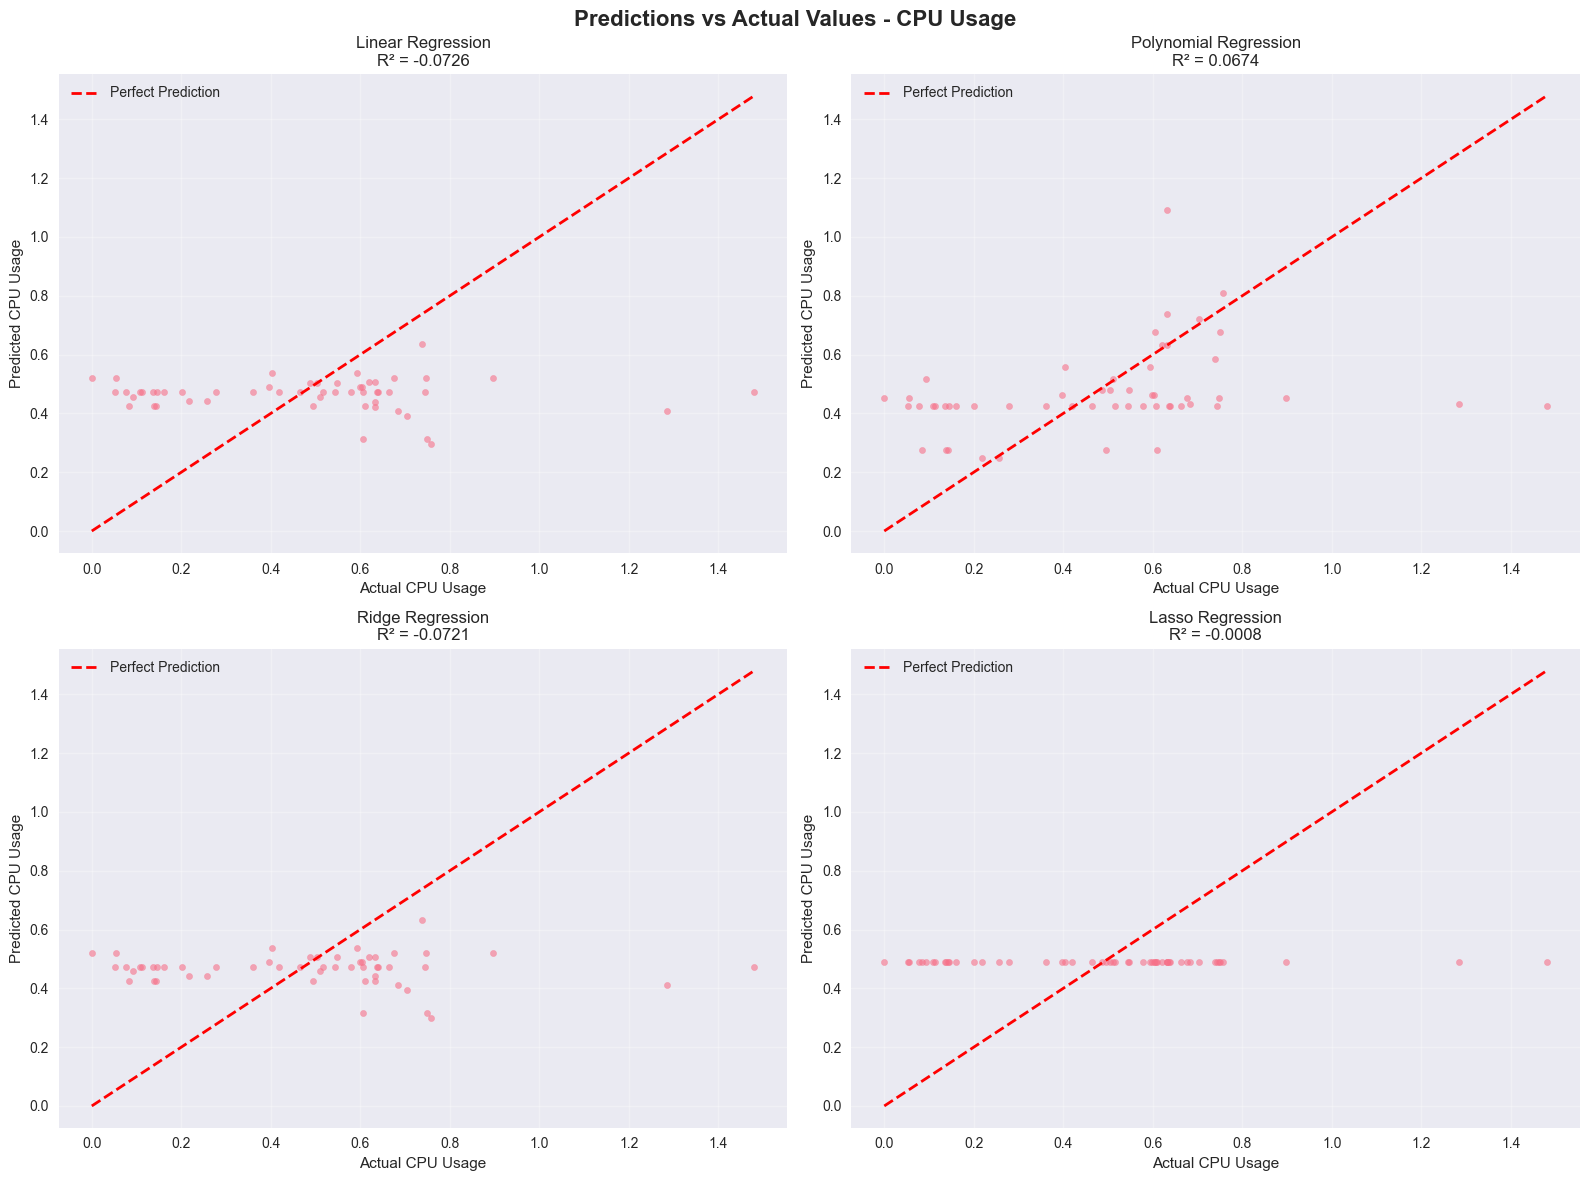

In [23]:
# Predictions vs Actual plots for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Predictions vs Actual Values - CPU Usage', fontsize=16, fontweight='bold')

model_names = list(results.keys())
for i, model_name in enumerate(model_names):
    row, col = i // 2, i % 2
    
    predictions = results[model_name]['predictions']
    actual_cpu = y_test[:, 0]
    predicted_cpu = predictions[:, 0]
    
    # Scatter plot
    axes[row, col].scatter(actual_cpu, predicted_cpu, alpha=0.6, s=20)
    
    # Perfect prediction line
    min_val = min(actual_cpu.min(), predicted_cpu.min())
    max_val = max(actual_cpu.max(), predicted_cpu.max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = results[model_name]['test_metrics'].get('r2_cpu', 0)
    
    axes[row, col].set_title(f'{model_name.replace("_", " ").title()}\nR² = {r2:.4f}')
    axes[row, col].set_xlabel('Actual CPU Usage')
    axes[row, col].set_ylabel('Predicted CPU Usage')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

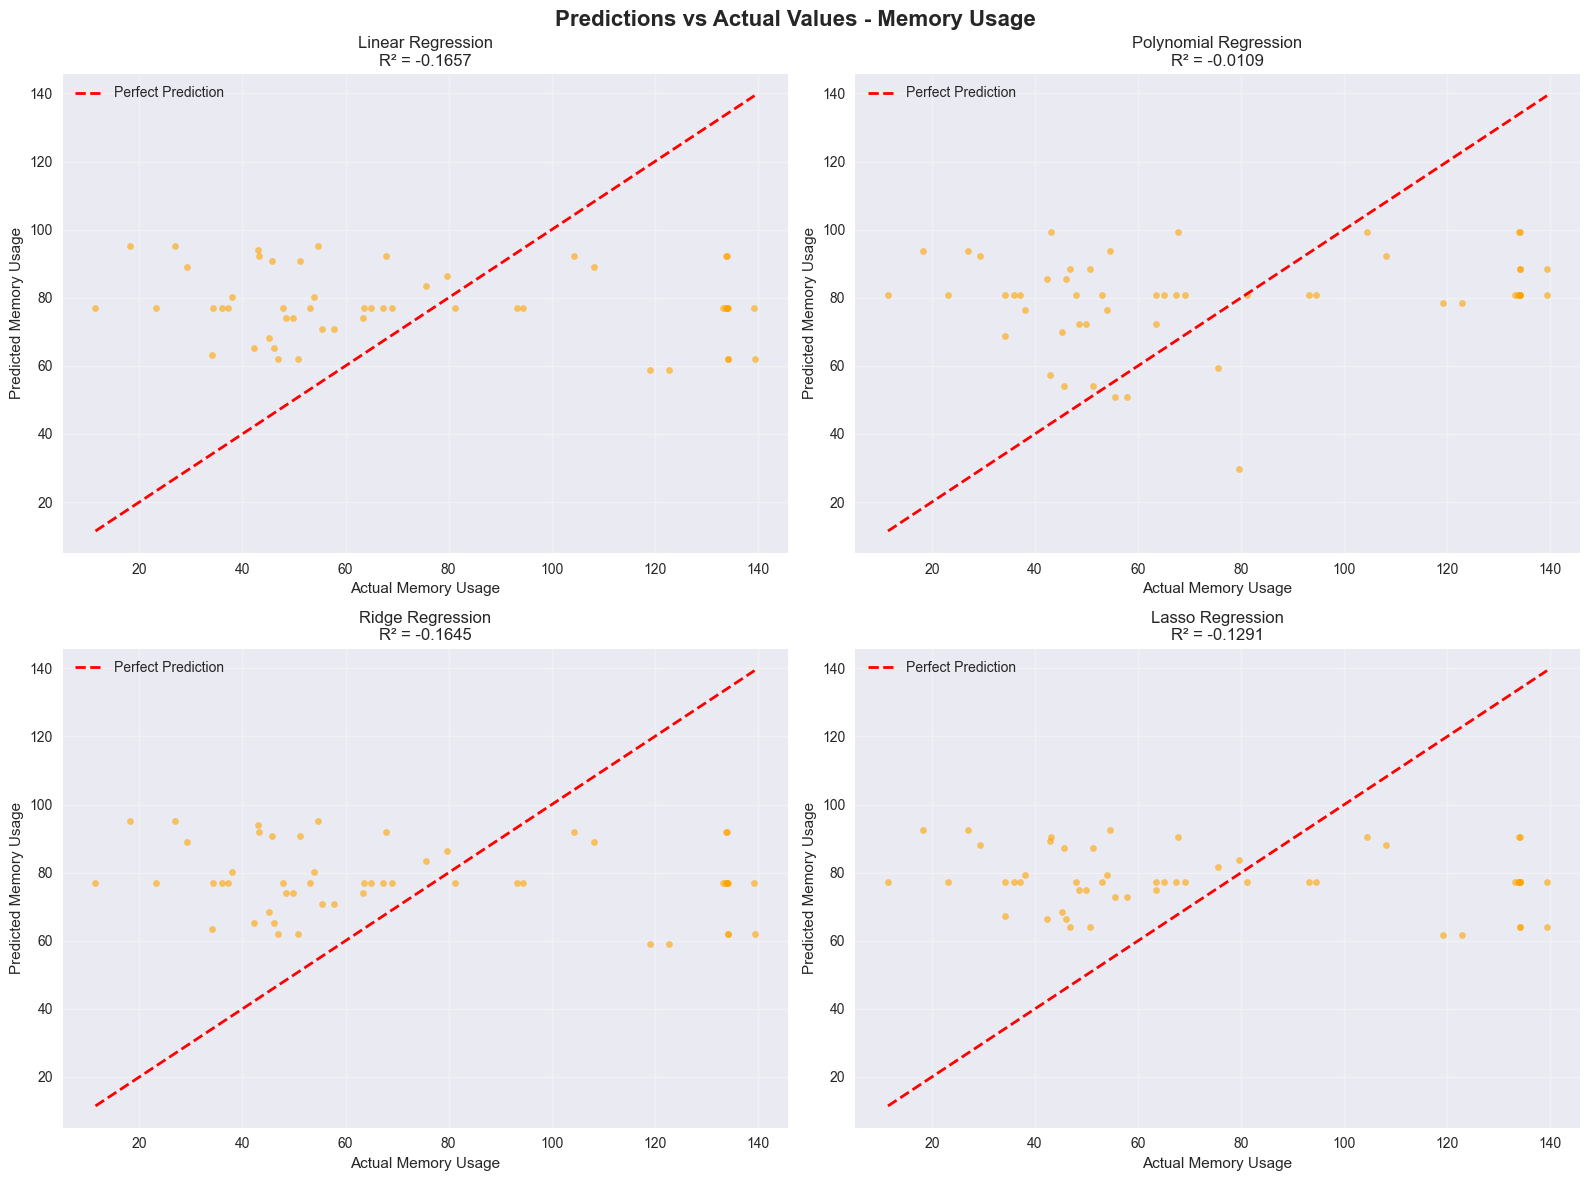

In [24]:
# Memory usage predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Predictions vs Actual Values - Memory Usage', fontsize=16, fontweight='bold')

for i, model_name in enumerate(model_names):
    row, col = i // 2, i % 2
    
    predictions = results[model_name]['predictions']
    actual_memory = y_test[:, 1]
    predicted_memory = predictions[:, 1]
    
    # Scatter plot
    axes[row, col].scatter(actual_memory, predicted_memory, alpha=0.6, s=20, color='orange')
    
    # Perfect prediction line
    min_val = min(actual_memory.min(), predicted_memory.min())
    max_val = max(actual_memory.max(), predicted_memory.max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = results[model_name]['test_metrics'].get('r2_memory', 0)
    
    axes[row, col].set_title(f'{model_name.replace("_", " ").title()}\nR² = {r2:.4f}')
    axes[row, col].set_xlabel('Actual Memory Usage')
    axes[row, col].set_ylabel('Predicted Memory Usage')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()